<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">
Import Libraries and Load Features

In [2]:
# Import necessary libraries and functions
%run VGG_feature_extractor.py
from VGG_feature_extractor import VGGNet
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import pytesseract
from PIL import Image
import pickle
import os

# Read features database (HDF5 file)
h5f = h5py.File("CombinedFeatures.h5", 'r')
feats = h5f['dataset_1'][:]
imgNames = h5f['dataset_2'][:]
h5f.close()


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">
Read Query Image and Extract Features

In [3]:
# Load the vectorizer
with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Define the path to your query image
queryImg = "query_images/0.jpg"
print("Searching for similar images")

# Initialize the VGGNet model for feature extraction
model = VGGNet()

# Extract VGG-16 image features from the query image
X_image = model.extract_feat(queryImg)

# Function to extract text features from the query image
def extract_text(image_path):
    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return ""

# Extract text features from the query image
text = extract_text(queryImg)
texts = [text]

# Check if text is present in the query image
if text.strip():
    text_features = vectorizer.transform(texts).toarray()
    X_query = np.hstack((X_image, text_features[0]))
else:
    # Handle the case where there is no text in the query image
    text_features = np.zeros((1, vectorizer.transform(['']).shape[1]))
    X_query = np.hstack((X_image, text_features[0]))

Searching for similar images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">
Compute Cosine similarity and Retrieve Top Matches

In [4]:
# Compute the Cosine similarity between the query features and dataset features
scores = []
for i in range(feats.shape[0]):
    score = 1 - cosine(X_query, feats[i])
    scores.append(score)
scores = np.array(scores)

# Sort the scores and retrieve the top matches
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

# Retrieve the top 5 matches to the query image
maxres = 5
imlist = [imgNames[index] for index in rank_ID[:maxres]]
print("Top %d images in order are: " % maxres, imlist)

# Define the path to your images directory
images_path = "all_images/"

Top 5 images in order are:  [b'0.jpg', b'9.jpg', b'80.jpg', b'84.jpg', b'85.jpg']


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">
Display Top Matching Images

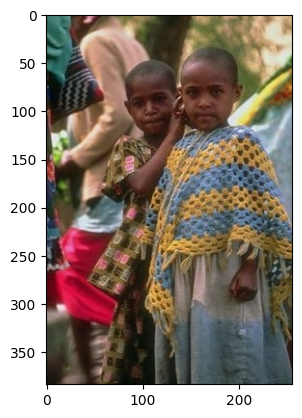

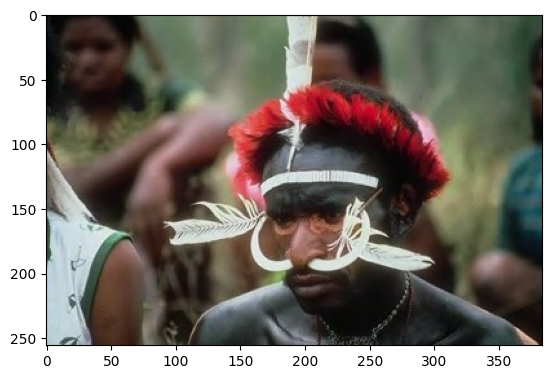

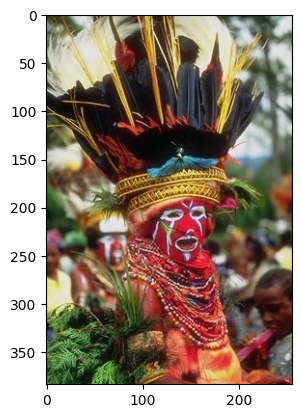

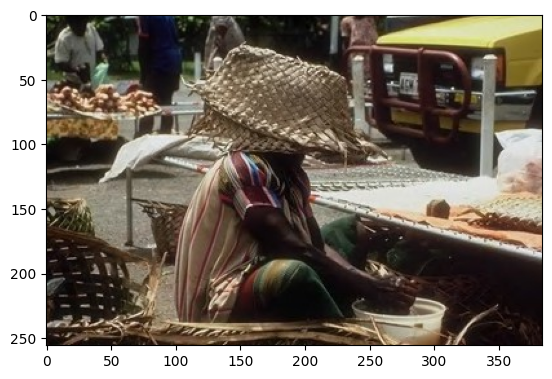

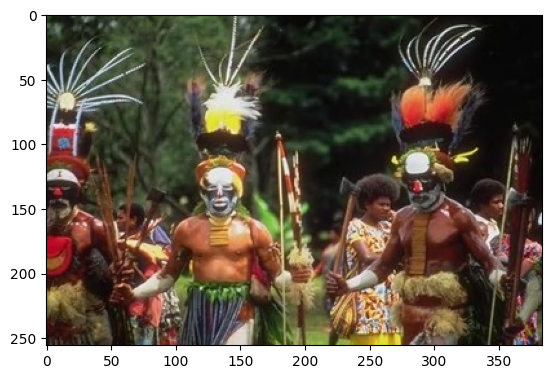

In [5]:
# Display the top matching images
for im_path in imlist:
    image = Image.open(os.path.join(images_path, im_path.decode('utf-8')))
    plt.imshow(image)
    plt.show()